# Vision part of the Mobile Robotics project

## Notes about the project and innput advancement

Dimensions of the thymio : 11 cm x 11.2 cm x 5.3 cm (https://wiki.thymio.org/fr:thymiospecifications).

I'll then choose 12-cm side squares for the start and end of the thymio, respectively green and blue.

## Imports

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time
import vision_utils as utils
import threading

### Loading image

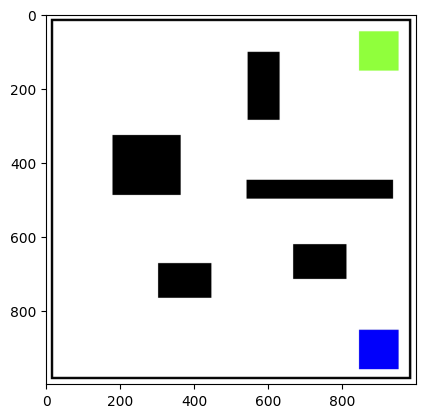

In [2]:
# Clear all the previous variables
# %reset -f

# Load the image
image = cv2.imread('map_mobilerobotics.jpeg')

#Resize this image to 1mx1m
image = cv2.resize(image, (1000, 1000))

# Convert the image from BGR to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(image)
plt.show()

## Preprocessing

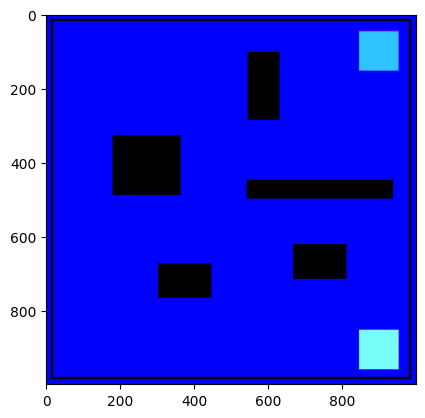

In [3]:
# Convert the image to HSV
hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

# Display the image
plt.imshow(hsv)
plt.show()

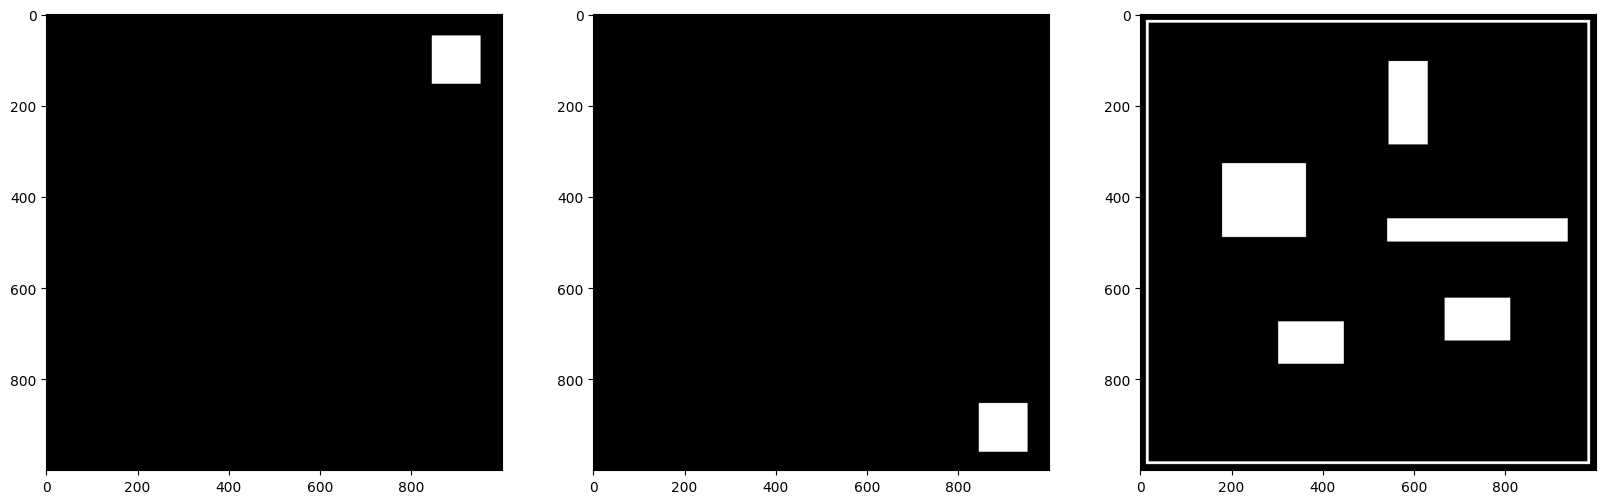

In [4]:
# Define color ranges for green squares
green_lower = np.array([35, 100, 100])
green_upper = np.array([85, 255, 255])
green_mask = cv2.inRange(hsv, green_lower, green_upper)

# Define color ranges for blue squares
blue_lower = np.array([100, 100, 100])
blue_upper = np.array([140, 255, 255])
blue_mask = cv2.inRange(hsv, blue_lower, blue_upper)

# Define color ranges for black squares or rectangles
black_lower = np.array([0, 0, 0])
black_upper = np.array([180, 255, 30])
black_mask = cv2.inRange(hsv, black_lower, black_upper)

#display the 3 masks
plt.figure(figsize=(20,10))
plt.subplot(131)
plt.imshow(green_mask, cmap="gray")
plt.subplot(132)
plt.imshow(blue_mask, cmap="gray")
plt.subplot(133)
plt.imshow(black_mask, cmap="gray")
plt.show()


In [5]:
# Find contours for each colour
green_contours, _ = cv2.findContours(green_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
blue_contours, _ = cv2.findContours(blue_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
black_contours, _ = cv2.findContours(black_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
black_contours = black_contours[2:] # Exclude the map contour

# Display the variables
print("Green contours: ", len(green_contours))
print("Blue contours: ", len(blue_contours))
print("Black contours: ", len(black_contours))

Green contours:  1
Blue contours:  1
Black contours:  5


In [6]:
# Draw contours on the original image
#Code for orange

cv2.drawContours(image, black_contours, -1, (0, 255, 255), 3);  # Red       color for   black   squares
cv2.drawContours(image, green_contours, -1, (0, 165, 255), 3);  # Orange    color for   green   squares
cv2.drawContours(image, blue_contours, -1, (255, 0, 0), 3);     # Yellow    color for   blue    squares


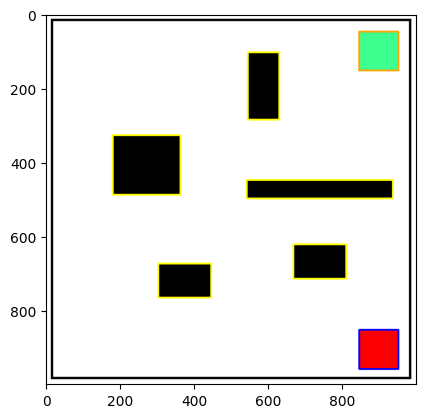

In [7]:
# Display the image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

In [8]:
for cnt in blue_contours:
 approx = cv2.approxPolyDP(cnt, 0.009 * cv2.arcLength(cnt, True), True)
 if len(approx) == 4:
     x, y, w, h = cv2.boundingRect(cnt)
     print(f'Blue square found at coordinates: {x}, {y}')

for cnt in green_contours:
 approx = cv2.approxPolyDP(cnt, 0.009 * cv2.arcLength(cnt, True), True)
 if len(approx) == 4:
     x, y, w, h = cv2.boundingRect(cnt)
     print(f'Green square found at coordinates: {x}, {y}')

for cnt in black_contours:
 approx = cv2.approxPolyDP(cnt, 0.009 * cv2.arcLength(cnt, True), True)
 if len(approx) == 4:
     x, y, w, h = cv2.boundingRect(cnt)
     print(f'Black square found at coordinates: {x}, {y}')


Blue square found at coordinates: 846, 853
Green square found at coordinates: 846, 47
Black square found at coordinates: 303, 674
Black square found at coordinates: 668, 622
Black square found at coordinates: 542, 448
Black square found at coordinates: 180, 327
Black square found at coordinates: 545, 103


In [9]:
# Define the coordinates of the map
map_coordinates = [(0, 0), (0, 1000), (1000, 1000), (1000, 0)]

# Export all the coordinates of the squares with tuples
# Blue squares
blue_coordinates = []
for cnt in blue_contours:
 approx = cv2.approxPolyDP(cnt, 0.009 * cv2.arcLength(cnt, True), True)
 if len(approx) == 4:
     x, y, w, h = cv2.boundingRect(cnt)
     blue_coordinates.append((x, y))

# Green squares
green_coordinates = []
for cnt in green_contours:
 approx = cv2.approxPolyDP(cnt, 0.009 * cv2.arcLength(cnt, True), True)
 if len(approx) == 4:
     x, y, w, h = cv2.boundingRect(cnt)
     green_coordinates.append((x, y))

# Black rectangles
black_coordinates = []
for cnt in black_contours:
 approx = cv2.approxPolyDP(cnt, 0.009 * cv2.arcLength(cnt, True), True)
 if len(approx) == 4:
     x, y, w, h = cv2.boundingRect(cnt)
     black_coordinates.append((x, y))

### Here are the output coordinates in tuples ###

# Sort the coordinates
blue_coordinates.sort()
green_coordinates.sort()
black_coordinates.sort()

# Display the coordinates
print("Blue coordinates: ", blue_coordinates)
print("Green coordinates: ", green_coordinates)
print("Black coordinates: ", black_coordinates)


Blue coordinates:  [(846, 853)]
Green coordinates:  [(846, 47)]
Black coordinates:  [(180, 327), (303, 674), (542, 448), (545, 103), (668, 622)]


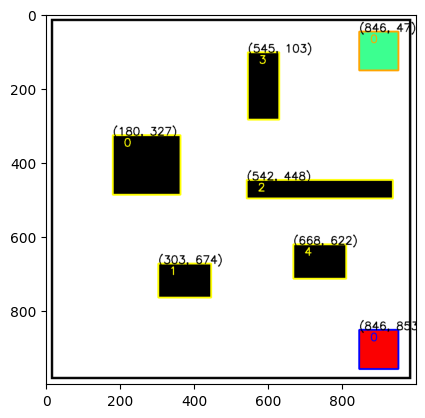

In [10]:
# Next to each square, write in black the coordinate of the top left corner of the square with size font 100
for i in range(len(blue_coordinates)):
    cv2.putText(image, f'{blue_coordinates[i]}', blue_coordinates[i], cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)
    cv2.putText(image, str(i), (blue_coordinates[i][0] + 30, blue_coordinates[i][1] + 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
for i in range(len(green_coordinates)):
    cv2.putText(image, f'{green_coordinates[i]}', green_coordinates[i], cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)
    cv2.putText(image, str(i), (green_coordinates[i][0] + 30, green_coordinates[i][1] + 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 165, 255), 2)
for i in range(len(black_coordinates)):
    cv2.putText(image, f'{black_coordinates[i]}', black_coordinates[i], cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)
    cv2.putText(image, str(i), (black_coordinates[i][0] + 30, black_coordinates[i][1] + 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)

# Display the image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

In [11]:
robot_position = [(100, 50), (150,50)]  # Replace with actual robot positions
path = [(150, 150), (250, 250), (350, 350)]  # Example path points
start = (50, 50)
end = (450, 450)

In [12]:
# Example points and path


# Draw on the image
utils.draw_points(image, robot_position,color=utils.ROBOT_COLOR)
utils.draw_points(image, path, color=utils.POINT_COLOR)
utils.draw_arrow(image, robot_position[0], robot_position[1], color=utils.ROBOT_COLOR)
utils.draw_path(image,start,end,path,color=utils.PATH_COLOR)

# Display the image
# cv2.imshow('Image', image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

## Displaying the video

In [13]:
def camera_thread():
    try:
        cap = cv2.VideoCapture(0)

        if not cap.isOpened():
            print("Error opening video stream or file")
            return

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            utils.frame_draw(frame, robot_position, path, start, end)
            cv2.imshow('Frame', frame)

            if cv2.waitKey(25) & 0xFF == ord('q'):
                break

            time.sleep(0.01)

    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        cap.release()
        cv2.destroyAllWindows()
        print("Done displaying the video")


## Filtering

In [14]:
cam_thread = threading.Thread(target=camera_thread)

In [15]:
cam_thread.start()

In [16]:
#cam_thread.join()

Done displaying the video
